# Larmor radius

How to set the maximum step size in CRPropa?

In [25]:
import numpy as np
from astropy import units as u
from astropy import constants
import matplotlib.pyplot as plt  # version 3.5.1
import itertools

# Style plot
plt.rcParams.update({'font.size': 18, 
                     'figure.figsize': (12, 10), 
                     'axes.grid.which': 'both',
                     'grid.color': 'lightgrey', 
                     'grid.linestyle': 'dotted', 
                     'axes.grid': True, 
                     'axes.labelsize': 24,
                     'legend.fontsize': 14,
                     'ytick.minor.visible': True}
                   )
plt.style.use('tableau-colorblind10')
MARKERS = itertools.cycle(['o', 's', '^', 'D', 'd', 'X', 'h', 'x'])\
# https://viscid-hub.github.io/Viscid-docs/docs/dev/styles/tableau-colorblind10.html
COLORS = itertools.cycle(["#006BA4", "#FF800E", "#ABABAB", "#595959",
          "#5F9ED1", "#C85200", "#898989", "#A2C8EC", "#FFBC79", "#CFCFCF"])

# Dictionary to use for neater plot legend with LaTeX format
B_GAUSS_DICT = {1e-12: "$B = 10^{-12}$",
                1e-13: "$B = 10^{-13}$", 
                5e-14: "$B = 5 \cdot 10^{-14}$", 
                6e-14: "$B = 6 \cdot 10^{-14}$",
                1e-15: "$B = 10^{-15}$", 
                1e-17: "$B = 10^{-17}$",
                5e-18: "$B = 5 \cdot 10^{-18}$"
               }

Minimum Larmor radius: 1.0810076114204198e-06 Mpc for B = 1e-13 G
Minimum Larmor radius: 2.1620152228408396e-06 Mpc for B = 5e-14 G


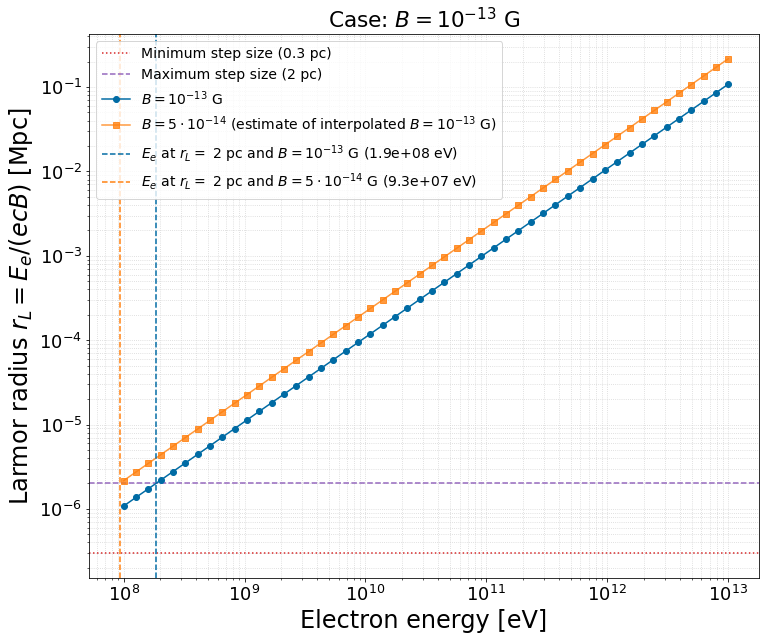

Minimum Larmor radius: 0.010810076114204198 Mpc for B = 1e-17 G
Minimum Larmor radius: 0.021620152228408396 Mpc for B = 5e-18 G


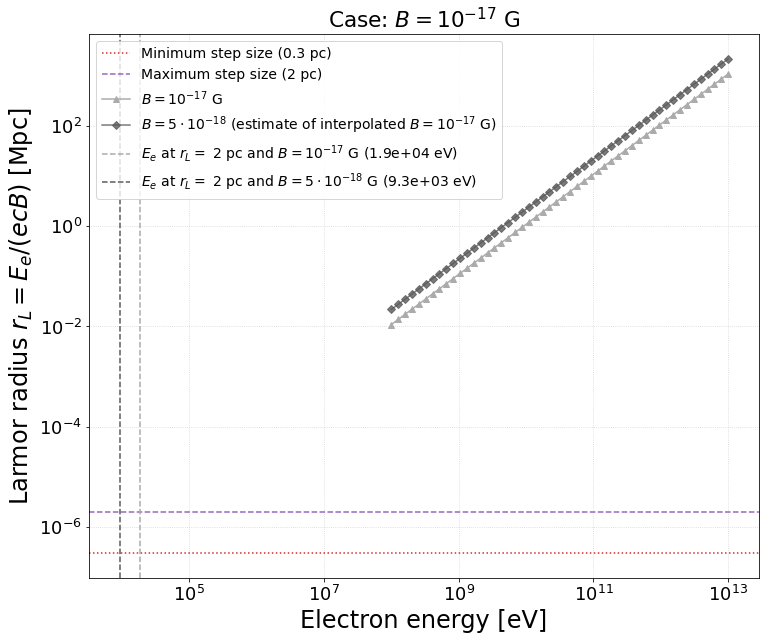

In [26]:
def get_larmor_radius(electron_energy_joules, magnetic_field_teslas):
    """Calculate Larmor radius using the equation in Section II of 
    https://arxiv.org/abs/2408.08818 : E_e/(e c B).
    Input parameters must be in SI units because astropy.constants are in SI units.
    
    Parameters
    ----------
    electron_energy_joules : array_like[float] or float
        Electron/positron energy in Joules.
    magnetic_field_teslas : float
        Magnetic field intensity in Teslas.
        
    Returns
    -------
    r_mpc : array_like[float] or float
        Larmor radius in Mpc
    """
    # Larmor radius in meters, E_e/(e c B)
    r_meters = electron_energy_joules / (constants.e.si * constants.c.si * magnetic_field_teslas)
    r_mpc = u.m.to(u.Mpc, r_meters)
    print(f"Minimum Larmor radius: {min(r_mpc.value)} Mpc for B = {u.T.to(u.G, magnetic_field_teslas)} G")
    
    return r_mpc


def plot_larmor_radius_vs_energy(b_gauss, min_r=2, plot_interpolation=True, interpolation_factor=0.5):
    """Plot Larmor radius in Mpc vs electron/positron energy in eV.
    Note that for a given |B|, the Larmor radius is an upper limit due to 
    trilinear interpolation of the grid tending to decrease |B| by ~50% 
    (and always between 1-99%).
    
    Parameters
    ----------
    b_gauss: array_like[float]
        Magnetic field in Gauss
    plot_interpolation : bool
        If True, estimates effect of interpolating a grid filled with `b_gauss` 
        by adjusting magnetic field by a factor of `interpolation_factor` = 0.5
        Interpolation has ROUGHLY the effect of *decreasing* the magnitude by 50%
    min_r : float
        Minimum step size; will be treated as Larmor radius
    """
    
    # Create electron energies in eV over the simulation energies which are tracked or injected
    # Minimum tracked energy is 1e8 eV
    energy_arr_ev = np.logspace(8, 13)
    
    # Plot Larmor radius for each B field
    fig, ax = plt.subplots(1, 1)
    ax.axhline(u.pc.to(u.Mpc, 0.3), color="tab:red", ls=":", label="Minimum step size (0.3 pc)")
    ax.axhline(u.pc.to(u.Mpc, min_r), color="tab:purple", ls="--", label="Maximum step size (2 pc)")
    
    for i, b in enumerate(b_gauss):
        # Color for `b`
        cb = next(COLORS)
        # Color for interpolated `b`
        cbi = next(COLORS)
        c = [cb, cbi]
        # Must convert to SI units
        b_tesla = u.G.to(u.T, b)
        line, = ax.plot(energy_arr_ev, get_larmor_radius(u.eV.to(u.J, energy_arr_ev), b_tesla), 
                marker=next(MARKERS), color=cb, 
                label=rf"{B_GAUSS_DICT[b]} G")
        # Plot one interpolated line if `b_gauss` is a list, so plot doesn't get cluttered
        if i == 0 and plot_interpolation:
            # Add impact of interpolation
            ax.plot(energy_arr_ev, get_larmor_radius(u.eV.to(u.J, energy_arr_ev), b_tesla*interpolation_factor), 
                marker=next(MARKERS), color=cbi,
                label=rf"{B_GAUSS_DICT[b*interpolation_factor]} (estimate of interpolated {B_GAUSS_DICT[b]} G)",
                alpha=0.8)
        for j, _b in enumerate([b, b*interpolation_factor]):
            E_e = electron_energy_from_larmor_radius(r_pc=min_r, magnetic_field_teslas=u.G.to(u.T, _b))
            ax.axvline(E_e, color=c[j], ls="--",
                   label=rf"$E_e$ at $r_L = $ {min_r} pc and {B_GAUSS_DICT[_b]} G ({E_e:.1e} eV)")
    
        
    ax.loglog()
    if len(b_gauss) == 1:
        plt.title(rf"Case: {B_GAUSS_DICT[b]} G")
    ax.legend()
    ax.set_xlabel('Electron energy [eV]')
    ax.set_ylabel(r'Larmor radius $r_L = E_e/(ecB)$ [Mpc]')
    ax.minorticks_on() 
    plt.show()
    

def electron_energy_from_larmor_radius(r_pc, magnetic_field_teslas):
    """Electron energy in eV given Larmor radius.
    
    Parameters
    ----------
    r_pc : float or array_like[float]
        Larmor radius in pc
    """
    # Larmor radius in meters, E_e/(e c B)
    r_meters = u.pc.to(u.m, r_pc)
    electron_energy_joules = r_meters * constants.e.si * constants.c.si * magnetic_field_teslas
    return u.J.to(u.eV, electron_energy_joules).value
    

for B in [1e-13, 1e-17]: 
    plot_larmor_radius_vs_energy([B])

# Electron energy at given radius
If the max step size is limited to 2 pc, what is the corresponding electron energy?

In [3]:
E_e = electron_energy_from_larmor_radius(r_pc=2, magnetic_field_teslas=u.G.to(u.T, 1e-13))
print(f"{E_e:.2e} eV")

1.85e+08 eV
